In [ ]:
%pip install pandas seaborn matplotlib

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

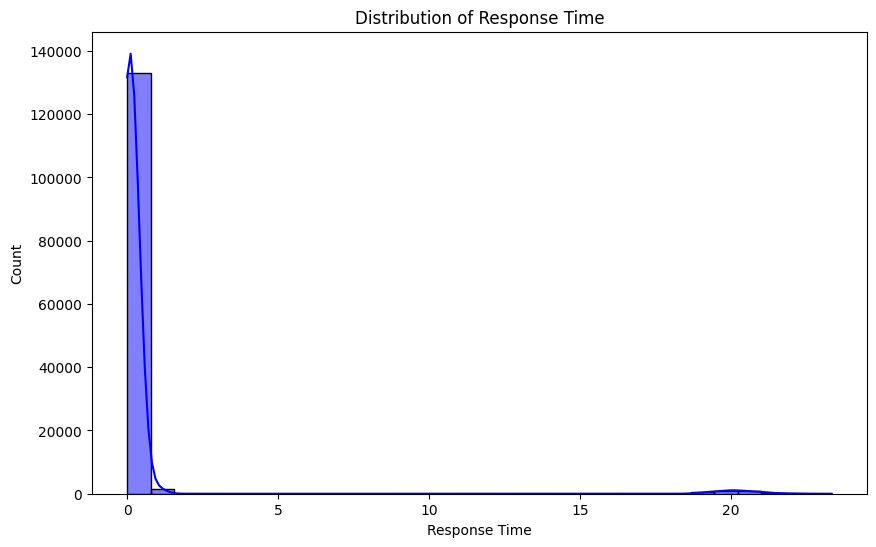

/var/folders/wk/l8__rsrn5v73832q54dxsh480000gn/T/ipykernel_20121/2905626089.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='status_code', palette='viridis')


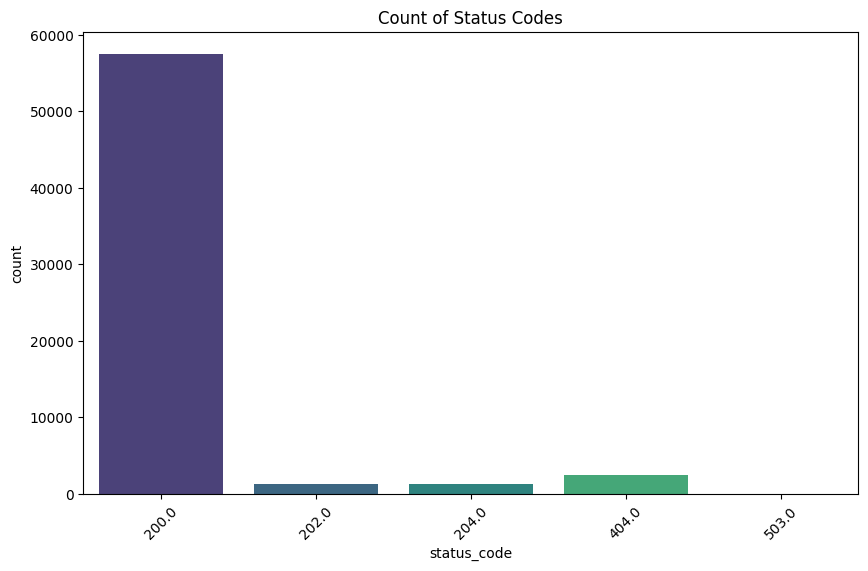

Number of anomalies: 9376
                  timestamp log_level                          source  \
0   2017-05-16 15:15:54.960      INFO            nova.compute.manager   
8   2017-05-16 15:16:02.909      INFO  nova.osapi_compute.wsgi.server   
66  2017-05-16 15:16:23.801      INFO            nova.compute.manager   
69  2017-05-16 15:16:23.947      INFO            nova.compute.manager   
82  2017-05-16 15:16:30.931      INFO       nova.metadata.wsgi.server   

                              request_id                           user_id  \
0   7a738b84-d574-43c6-a6c4-68c164365101  e887c6de57b5411cb33a5943be2d3c1a   
8   ebab86b4-70ec-4d4f-bad3-a50e0afa0ff8  113d3a99c3da401fbd62cc2caa5b96d2   
66  ebab86b4-70ec-4d4f-bad3-a50e0afa0ff8  113d3a99c3da401fbd62cc2caa5b96d2   
69  ebab86b4-70ec-4d4f-bad3-a50e0afa0ff8  113d3a99c3da401fbd62cc2caa5b96d2   
82                                   NaN                               NaN   

                          project_id       internal_ip  \
0   54fa

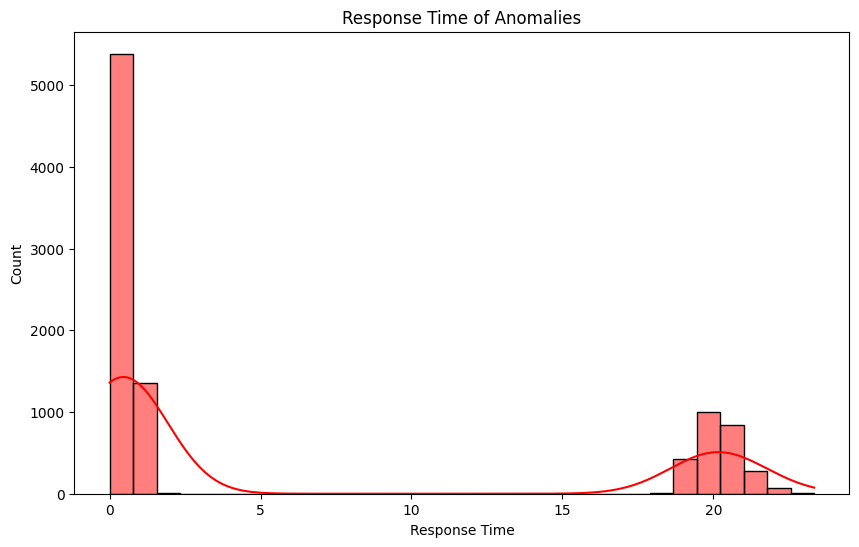

Anomalies saved to anomalies/anomalies_train.csv
Anomalies saved to anomalies/anomalies_test.csv
Anomalies saved to anomalies/anomalies_predict.csv
Anomaly detection complete and results saved!


In [3]:
# Load preprocessed datasets
df_train = pd.read_csv('preprocessed/preprocessed_openstack_train.csv')
df_test = pd.read_csv('preprocessed/preprocessed_openstack_test.csv')
df_predict = pd.read_csv('preprocessed/preprocessed_openstack_predict.csv')

# Step 1: Visualize Data Distribution
def visualize_data_distribution(df):
    # Distribution of response_time
    plt.figure(figsize=(10, 6))
    sns.histplot(df['response_time'], kde=True, bins=30, color='blue')
    plt.title('Distribution of Response Time')
    plt.xlabel('Response Time')
    plt.show()

    # Count of status codes
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x='status_code', palette='viridis')
    plt.title('Count of Status Codes')
    plt.xticks(rotation=45)
    plt.show()

visualize_data_distribution(df_train)

# Step 2: Define Anomaly Detection Logic
def flag_anomalies(df, response_time_threshold, error_status_codes):
    # Flag anomalies
    df['is_anomalous'] = (
        (df['status_code'].isin(error_status_codes)) | 
        (df['response_time'] > response_time_threshold)
    )
    
    return df

# 99th percentile for stricter filtering
response_time_threshold = 0.95;

# If too few anomalies are flagged, lower the threshold (e.g., use the 95th percentile for response time).
# If too many anomalies are flagged, increase the threshold or narrow the error codes.

# Adjust thresholds based on analysis
response_time_threshold = df_train['response_time'].quantile(response_time_threshold)

# Focus on critical errors
error_status_codes = [401, 403, 404, 500, 503]

# Apply anomaly detection to all datasets
df_train = flag_anomalies(df_train, response_time_threshold, error_status_codes)
df_test = flag_anomalies(df_test, response_time_threshold, error_status_codes)
df_predict = flag_anomalies(df_predict, response_time_threshold, error_status_codes)

# Step 3: Validate Anomalies
def validate_anomalies(df):
    # Check anomalies
    anomalies = df[df['is_anomalous']]
    print(f"Number of anomalies: {len(anomalies)}")
    
    # Display flagged anomalies
    print(anomalies.head())

    # Visualize anomalies
    plt.figure(figsize=(10, 6))
    sns.histplot(anomalies['response_time'], kde=True, bins=30, color='red')
    plt.title('Response Time of Anomalies')
    plt.xlabel('Response Time')
    plt.show()

validate_anomalies(df_train)

# Step 4: Save Anomalies
def save_anomalies(df, file_name):
    # anomalies = df[df['is_anomalous']]
    # anomalies.to_csv(file_name, index=False)
    df.to_csv(file_name, index=False)
    print(f"Anomalies saved to {file_name}")

# Save flagged anomalies
save_anomalies(df_train, "anomalies/anomalies_train.csv")
save_anomalies(df_test, "anomalies/anomalies_test.csv")
save_anomalies(df_predict, "anomalies/anomalies_predict.csv")

print("Anomaly detection complete and results saved!")


In [4]:
# Check flagged logs
print(df_train['is_anomalous'].value_counts())

# Inspect anomalies
anomalies = df_train[df_train['is_anomalous']]
print(anomalies.head())

is_anomalous
False    127698
True       9376
Name: count, dtype: int64
                  timestamp log_level                          source  \
0   2017-05-16 15:15:54.960      INFO            nova.compute.manager   
8   2017-05-16 15:16:02.909      INFO  nova.osapi_compute.wsgi.server   
66  2017-05-16 15:16:23.801      INFO            nova.compute.manager   
69  2017-05-16 15:16:23.947      INFO            nova.compute.manager   
82  2017-05-16 15:16:30.931      INFO       nova.metadata.wsgi.server   

                              request_id                           user_id  \
0   7a738b84-d574-43c6-a6c4-68c164365101  e887c6de57b5411cb33a5943be2d3c1a   
8   ebab86b4-70ec-4d4f-bad3-a50e0afa0ff8  113d3a99c3da401fbd62cc2caa5b96d2   
66  ebab86b4-70ec-4d4f-bad3-a50e0afa0ff8  113d3a99c3da401fbd62cc2caa5b96d2   
69  ebab86b4-70ec-4d4f-bad3-a50e0afa0ff8  113d3a99c3da401fbd62cc2caa5b96d2   
82                                   NaN                               NaN   

                     

In [5]:
# Check anomalies based on response_time threshold
response_time_anomalies = df_train[df_train['response_time'] > response_time_threshold]
print(f"Number of logs flagged by response_time threshold: {len(response_time_anomalies)}")

# Check anomalies based on status_code
status_code_anomalies = df_train[df_train['status_code'].isin(error_status_codes)]
print(f"Number of logs flagged by status_code: {len(status_code_anomalies)}")

# Combine
combined_anomalies = df_train[df_train['is_anomalous']]
print(f"Total anomalies flagged: {len(combined_anomalies)}")


Number of logs flagged by response_time threshold: 6851
Number of logs flagged by status_code: 2529
Total anomalies flagged: 9376
